# **Image Colour Thresholding**

Through this book, we will explore the idea of colour thresholding using `OpenCV` to seperate the lane markers from the road surface.

## **Imports**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from src.utility import *

In [2]:
orig_img = cv2.imread('book_images/top_view.png')

## **Motivation**

The concept of lane detection includes having an algorithm that is robust to various road conditions. Ideally, we would want the road to be as dark as possible and the lines to be as light as possible, making it easier to seperate the two. However this is almost never the case as we can have road surfaces that can be light or dark, lines that could be freshly painted or faded away, cracks or potholes, construction markers, etc. There are too many to list. Creating an algorithm that is robust enough to tackle every situation is a difficult and time consuming task. For our sake, we will focus on using colour spaces to tackle some of the simpler problems.

## **Colour Spaces**

Some of these simpler problems include varying road surface luminence, different coloured lines, and varying image brightness. These problems can be tackled by manipulating an image's colour spaces. Let's take a quick look at the different colour spaces we might use or encounter.

### RGB

This is the most common colour space used to display images as it accurately represents what our eyes see. It's an additive space containing channels for each pixel's respective red, green, and blue colour intensity ranging from 0 to 255. For example, a pure red would be represented as (255, 0, 0), a pure green as (0, 255, 0), white as (255, 255, 255), and black as (0, 0, 0). While this is great for displaying images, it's as useful for thresholding features as we cannot seperately control a colours luminence or intensity from other colours.

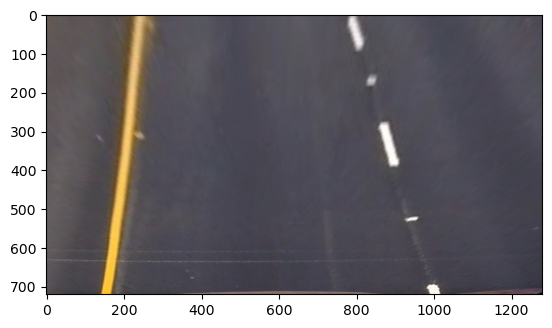

In [3]:
# OpenCV inherintly uses the BGR colour space when reading images.
# We need to convert the image to RGB.
rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb)

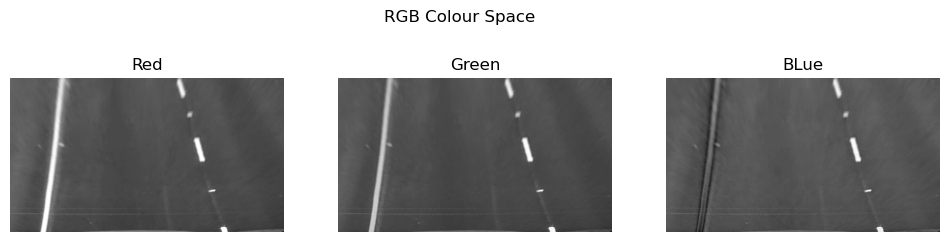

In [4]:
# Create a dictionary for plotting
rgb_dict = {
    'Red' : rgb[:,:,0],
    'Green' : rgb[:,:,1],
    'BLue' : rgb[:,:,2]
}

plot_channels(rgb_dict, 'RGB Colour Space')

We can see that the yellow (left) line has higher red and green intensities as compared to blue and the right (white) line has a similar intensity accross all three channels.

### Grayscale

After RGB, the next colour space you might be familiar with is monochrome, or grayscale. It's made up of a single channel of pixel intesities ranging from black (0) to white (255). Think of an RGB image, but only a single channel with the colour properties (hue and saturation) stripped and only intensity remains.

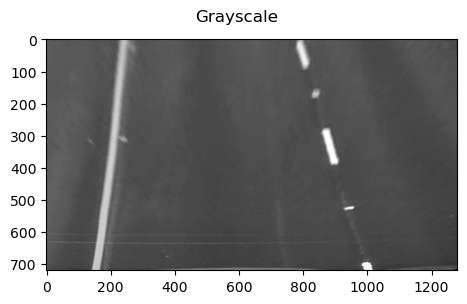

In [5]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

gray_dict = {'Gray' : gray}

plot_channels(gray_dict, 'Grayscale', ncols=1)

If we went back to our ideal situation of a dark road and bright lines (like our example image), we could convert the image to grayscale and easily seperate the lines from the road. If the road is dark, we know the intensity of the pixels of the road will be ranging closer to zero. Similarly if the lines are bright, we know that the pixels of the lines will be ranging closer to 255. We could apply a threshold to the image by making all of the darker intensities equal zero, and all of the brighter pixels equal to 255. This results in a binary image where either the pixel is on (1) or off (0). Let's quickly try this below.

Text(0.5, 1.0, 'Grayscale Binary Thresholding')

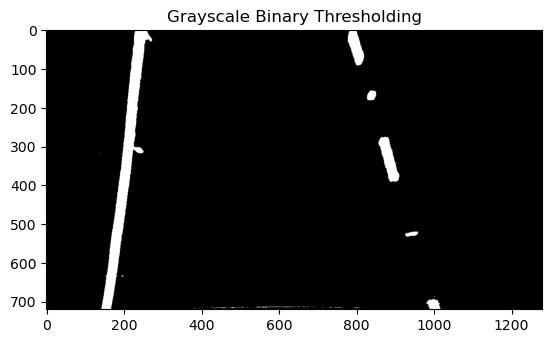

In [6]:
# Select a threshold value where all values above are 1 and all below are 0
threshold_value = 128

# Apply the threshold to the image
gray_thresh = np.zeros_like(gray)
gray_thresh[gray < threshold_value] = 0
gray_thresh[gray >= threshold_value] = 1


plt.imshow(gray_thresh, cmap='gray')
plt.title('Grayscale Binary Thresholding')

Hey, that did a pretty good job! But again, this is for idealisitic conditions. If you apply this method to different scenarios, you'd end up wasting too much time adjusting the threshold or creating other filters. Let's continue to explore other colour spaces and see if we can find one that helps us out more.

### HLS

The HLS colour space is more complicated to the last two we've explored as there is a little more to the colour theory. The acronym stands for Hue, Lightness, and Saturation. 

The `hue` channel is the shade of the colour as per the angle on a colour wheel where 0°/360° represents red, 120° for green, 240° for blue, and other shades inbetween those angles. 

The `lightness` channel essentially represents the brightness of the colour by adding a scalar value ranging from black (0%) to white (100%). If the lightness is lower, the colour will be darker because we are adding more black. Conversly, if the lightness is higher, the colour will be lighter because we are adding more white.

Lastly, the `saturation` is a representation of the intesity of the colour ranging from gray (0%) to the purist form of the colour (100%). Higher saturation means the colour is more vivid and lower saturation results in a more "muted" colour. 

I highly recommend reading this Wikipedia [page](https://en.wikipedia.org/wiki/HSL_and_HSV) for more details (we'll get to HSV later) and playing around with this [HLS calculator](https://hslpicker.com/).



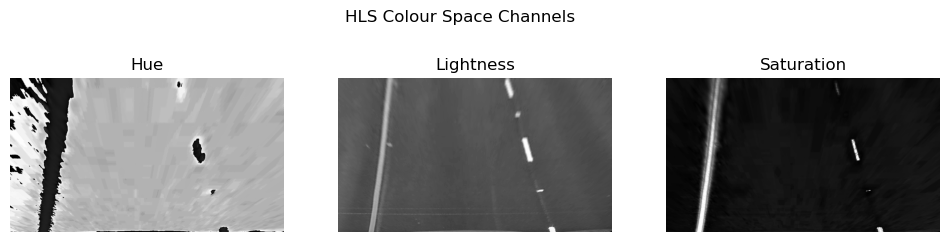

In [7]:
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)

hls_dict = {
    'Hue' : hls[:,:,0],
    'Lightness' : hls[:,:,1],
    'Saturation' : hls[:,:,2]
}

plot_channels(hls_dict, title='HLS Colour Space Channels')

The benefit from the increased complexity of the HLS colour space is that we have more fine control over the thresholding parameters. For example if we want to focus on detecting yellow lines we can limit the hue to maybe 30° to 60° (shades of yellowish orange), the lightness to 50% to 80% (dark to bright yellows without whites), and the saturation 50% to 100% (more pure yellows). Let's see what this looks like.

>**Note:** OpenCV2 uses different nomenclature for representing HLS Values. The hue values are values from 0 to 180, the colour wheel angles divided by 2. Both the lightness and saturation values are represented as a range of 0 to 255.

Text(0.5, 1.0, 'Thresholding HLS for Yellow')

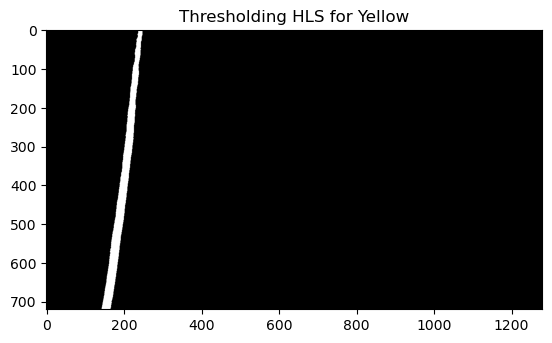

In [8]:
# Define lower threshold values for each channel
hls_lower_thresholds = np.array([
    int(30 / 2),
    int(0.50 * 255),
    int(0.50 * 255)
])

# Define upper threshold values for each channel
hls_upper_thresholds = np.array([
    int(60 / 2),
    int(0.80 * 255),
    int(1.00 * 255)
])

hls_thresh = cv2.inRange(hls, hls_lower_thresholds, hls_upper_thresholds)

plt.imshow(hls_thresh, cmap='gray')
plt.title('Thresholding HLS for Yellow')

Perfect, we've filtered for the yellow lane line only! Try to play around with the upper and lower threshold values a bit and see how adjusting the HLS values changes what gets selected.

### HSV

This colour space is similar to HLS, but varies slightly in how the colour is calculated. The first channel, `Hue`, is the exact same colour wheel angle as in HLS. The `Saturation` channel is similar to HLS, however it ranges from white (0%) to the purest form of the colour (100%) instead. Lastly, the `Value` channel is similar to the lightness channel as it describes the brightness. However it is closely related to the saturation as the values range from black (0%) to the purest form of the colour (100%).

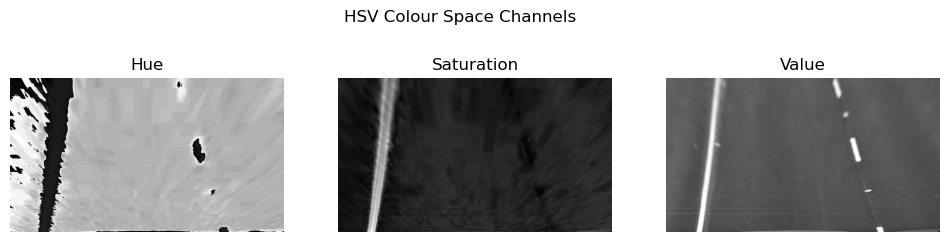

In [9]:
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

hsv_dict = {
    'Hue' : hsv[:,:,0],
    'Saturation' : hsv[:,:,1],
    'Value' : hsv[:,:,2]
}

plot_channels(hsv_dict, title='HSV Colour Space Channels')

### Comparing HLS to HSV

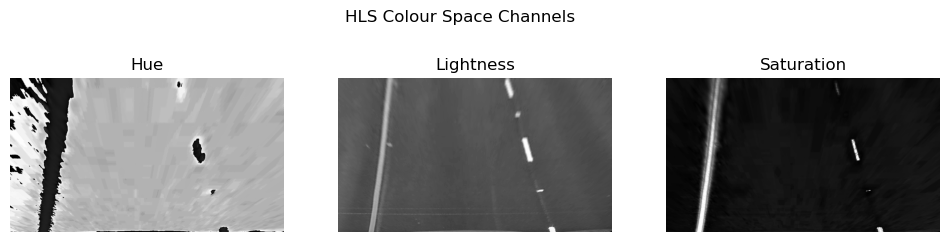

In [10]:
plot_channels(hls_dict, title='HLS Colour Space Channels')

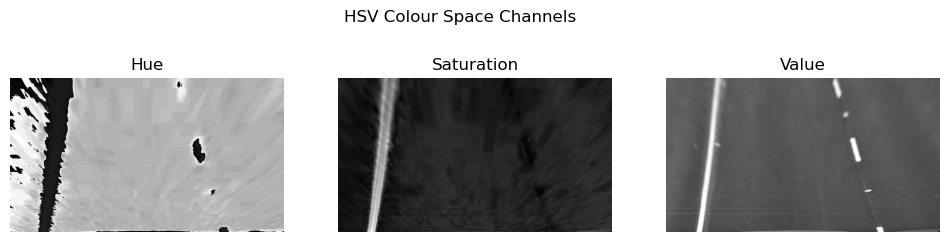

In [11]:
plot_channels(hsv_dict, title='HSV Colour Space Channels')

Take a moment to compare the differences between each saturation channel, and the value and lightness channels. Notice that the `saturation` channel from the HSV colour space does not clearly define the lines as compared to the same channel in HLS. The background (road) is also not pure black in HSV wheras in HSL it is. The primary difference comes from the fact that the saturation scale for HLS starts from **grey** and moves towards the purest colour whereas in HSV the scale starts from **white**.

The yellow (left) lane in in the `value` channel is also more intense as compared to the `lightness` channel. Again the difference comes from the scales. The value channel starts from black and moves towards the **purest** form of the colour wheras lightness starts from black and moves towards **white**.

>**Note:** There are many other colour spaces that you can investigate, but HLS and HSV have been used with a great deal of success in computer vision algorithms for thresholding.

## **Thresholding**

### **Grayscale Thresholding**

Great, now we understand some of the basics of both of these colour spaces! But why bother with the added complexity of these spaces when grayscale seemed to work pretty decently? Let's look at the bird's-eye-view of a few frames from the videos I tested.

In [12]:
pf_list = get_bev('output_media/debug/problem_frames/')

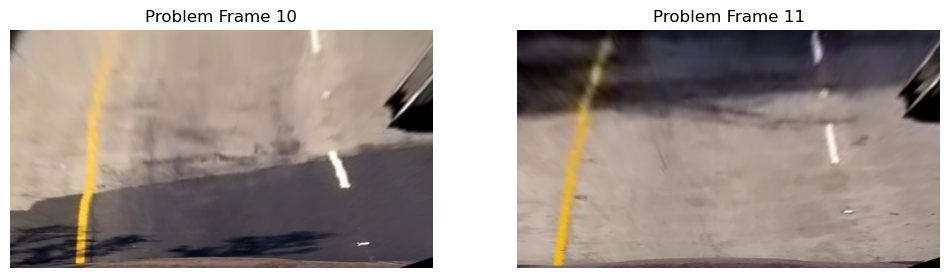

In [13]:
img_list = [pf_list[10], pf_list[11]]
title_list = ['Problem Frame 10', 'Problem Frame 11']

plot_row_images(img_list, title_list)

The biggest issue with these frames is that the road transitions from different shade intensities. The problem might not be too obvious right now, but let's convert them into grayscale to see the **pixel intensities**.

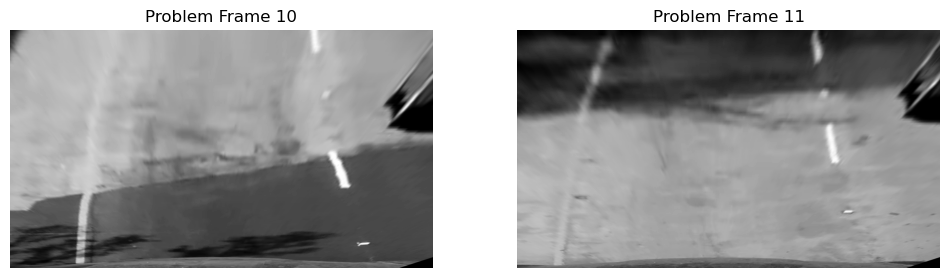

In [14]:
pf_10_gray = cv2.cvtColor(pf_list[10], cv2.COLOR_RGB2GRAY)
pf_11_gray = cv2.cvtColor(pf_list[11], cv2.COLOR_RGB2GRAY)

img_list = [pf_10_gray, pf_11_gray]

plot_row_images(img_list, title_list, cmap='gray')

Ah, now we see that its almost looks like the yellow lines are indiscernable from the light road. Let's try to apply binary thresholding and see what we can extract.

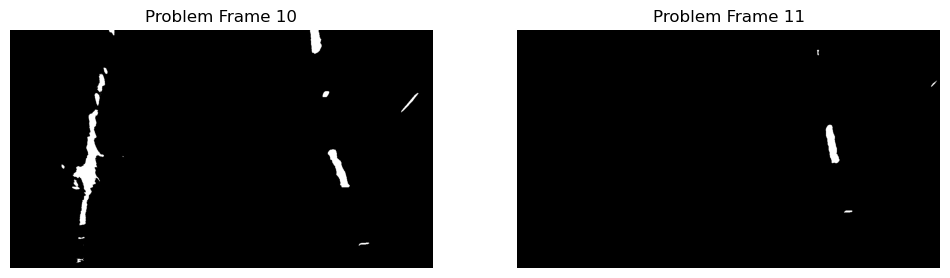

In [15]:
thresh = 200
pf_10_binary = binary_threshold(pf_10_gray, thresh)
pf_11_binary = binary_threshold(pf_11_gray, thresh)

img_list = [pf_10_binary, pf_11_binary]

plot_row_images(img_list, title_list, cmap='gray')

Okay, we've got both lines from **frame 10**, but only the white line from **frame 11**. Let's reduce the threshold until we can see the second line in **frame 11**.

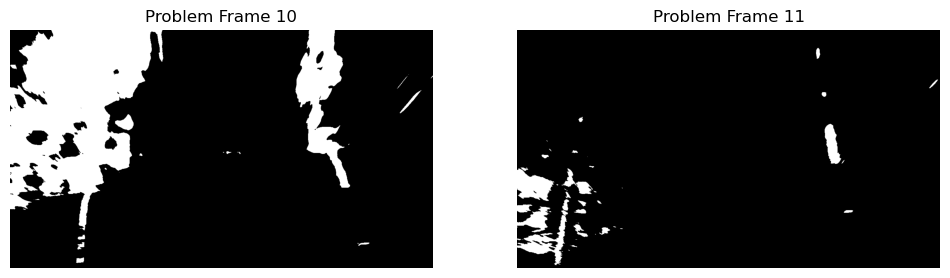

In [16]:
thresh = 180
pf_10_binary = binary_threshold(pf_10_gray, thresh)
pf_11_binary = binary_threshold(pf_11_gray, thresh)

img_list = [pf_10_binary, pf_11_binary]

plot_row_images(img_list, title_list, cmap='gray')

Once we started to lower the threshold to a value where the yellow line was being detected in **frame 11**, we also got a lot of noise as it started to pick up the light pixels of the road. And looking at **frame 10**, we now have a lot more noise than with the higher threshold. These two images are a good example as to why grayscale binary thresholding is sensitive to the road surface shading.

### HLS and HSV Thresholding

So what can be done about this? Well the HLS and HSV spaces give us finer control over specific colours.We know that road markers usually only come in a few select colours, white, yellow, orange, etc. Both HLS and HSV allow us to specify what **hue** range we want to work with, along with specific **saturation** and **luminence** levels. So we can create colour-specific threshold profiles to prevent adding noise when detecting colour mismatched lane markers, solving the issue we had with grayscale thresholding.

Previously we used HLS to find the yellow lane markers, but we saw that the **value** channel from HSV has an overall higher intensity over the **lightness** from HLS. Intuitively if the overall intensity of the line pixels are higher while the background stays the same, it will be easier to threshold from the background. We'll leverage this benefit to use HSV instead of HLS for yellow (or coloured) lines. Let's look at some HSV parameters that work for us.

>**Note:** You could theoretically only use HLS, however in my testing I found that through the varying conditions, HSV had more consistent results.

Text(0.5, 1.0, 'Thresholding HSV for Yellow')

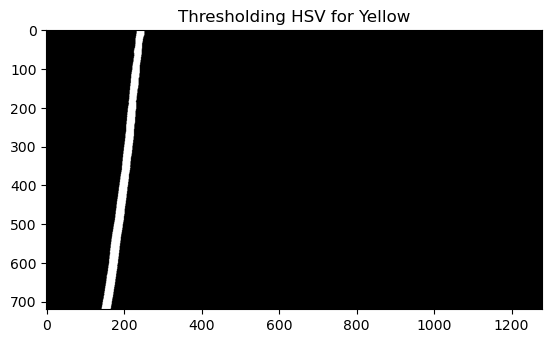

In [26]:
# Define upper and lower threshold bounds for each HSV channel
yellow_lower = np.array([int(30 / 2), int(0.10 * 255), int(0.75 * 255)])
yellow_upper = np.array([int(50 / 2), int(1.00 * 255), int(1.00* 255)])

# Threshold for yellow pixels
yellow = cv2.inRange(hsv, yellow_lower, yellow_upper)

plt.imshow(yellow, cmap='gray')
plt.title('Thresholding HSV for Yellow')

Now, we could use HSV to also detect the white lane markers as well. However, the **lightness** channel from HLS does a better job at consistently detecting white pixels due the inherint structure of the colour space.

The hue doesn't matter in this case, as white is not colour dependant. Saturation also has little effect because we will only focus on the top range of lightness values meaning that changing the saturation does not do much. We only have to threshold the lightness channel and select a range of values that works for us.

>**Note:** Like before, you might get decent results by using a single colour space. In my testing I found that HLS gave more consistent results for white lines.

Text(0.5, 1.0, 'Thresholding HLS for White')

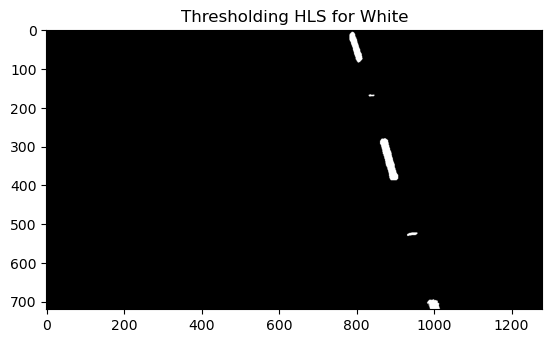

In [28]:
# Define upper and lower lightness channel threshold bounds
lightness_lower = np.array([195])
lightness_upper = np.array([255])

# Threshold lightness channel
lightness = cv2.inRange(hls[:, :, 1], lightness_lower, lightness_upper)

plt.imshow(lightness, cmap='gray')
plt.title('Thresholding HLS for White')

Now let's combine the two and see what our thresholded image looks like.

Text(0.5, 1.0, 'Combined Thresholding Output')

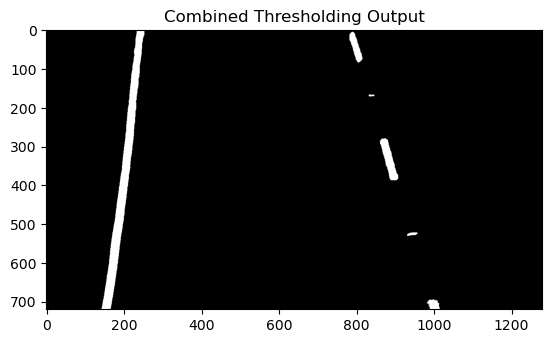

In [29]:
# Use OR logic to combine binary images
output = lightness | yellow

plt.imshow(output, cmap='gray')
plt.title('Combined Thresholding Output')

This looks great! We have successfully detected the pixels of the lines and it's a 2D array of binary values which makes it easier to operate on. The next step now is to perform a sliding window algorithm to fit a polyline over these detected pixels.